##### https://pythonmachinelearning.pro/face-recognition-with-eigenfaces/

##### The tutorial uses a full dataset of thousands of faces. I just kept the most-occuring ones, e.g. min_occurrences > 60 (or 80?)

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import numpy as np
import tensorflow as tf
import cv2

from getConfig import getConfig
from mapImageToClass import mapImageToClass

In [23]:
def preProcess(fileName):
    '''
    - Read the .jpg file
    - Convert from bytes to numpy
    '''
    rawBytes = tf.io.read_file(fileName)
    img = tf.image.decode_jpeg(rawBytes, channels=3)
    img = tf.cast(img, dtype=tf.float32)
    #img /= 255.0
    #img = tf.expand_dims(img, 0)
    return img

In [24]:
def createDataset(fileNames):
    ''' Create a dataset of all the image files (.jpg)
    'map' does the resizing and normalizing '''
    ds = tf.data.Dataset.from_tensor_slices(fileNames)
    return ds.map(preProcess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [26]:
def getFile(file):
    '''
    - "file" is the name of a .JPEG
    - Read it and get the grayscale version, downsampling from 3 channels to 1, just following the tutorial
    - Resize because training did not go well against the full image (250x250). Presumably the reduction in size from 62,000
    bytes down to 100 was too much
    - Flatten to make 2D (including other images as rows)'''
    imgData = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    imgData = cv2.resize(imgData, dsize=(47,62), interpolation=cv2.INTER_CUBIC)
    imgData = imgData.flatten()
    imgData = imgData.astype(float)
    '''rawBytes = tf.io.read_file(file)
    imgData = tf.image.decode_jpeg(rawBytes, channels=3)'''
    return imgData

In [27]:
config = getConfig()
'''
"imageClass" is fileName:Class, e.g. Tony_Blair_001.jpg: TonyBlair
classIdx is Class:integerValue, e.g. TonyBlair:3
idxClass is integerValue:Class, e.g. 3:TonyBlair '''
imageClass, classIdx = mapImageToClass(config)
# Also get the Class: Name mapping for looking at predictions
idxClass = {}
for k,v in classIdx.items():
    idxClass[v] = k

In [28]:
# These are the integerValues corresponding to a person, e.g Tony Blair is a 3
# The order of labels is important: has to match the data in trainX and testX
labels = [classIdx[imageClass[x]] for x in imageClass.keys()]

In [29]:
# Create a matrix of rows=images and cols=features (pixels)
images = []
for file in imageClass.keys():
    imgData = getFile(file)
    images.append(imgData)

images = np.array(images)
len(images)==len(labels)

True

In [77]:
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2)

In [62]:
# Normalize the data
mu = trainX.mean()
sigma = trainX.std()
trainX = (trainX - mu)/sigma
testX = (testX - mu)/sigma

In [78]:
# run PCA 
pcaSize = 100
pca = PCA(n_components=pcaSize, whiten=True).fit(trainX)

In [79]:
# apply PCA transformation
reducedTrain = pca.transform(trainX)
reducedTest = pca.transform(testX)

In [80]:
# Run the baseline NN
for _ in range(10):
    clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=False, early_stopping=True).fit(reducedTrain, trainY)
    print("Best validation score: {:.3f}".format(clf.best_validation_score_))

Best validation score: 0.837
Best validation score: 0.783
Best validation score: 0.870
Best validation score: 0.761
Best validation score: 0.859
Best validation score: 0.837
Best validation score: 0.815
Best validation score: 0.859
Best validation score: 0.728
Best validation score: 0.804


In [82]:
# Look at the results. Get predictions first
preds = clf.predict(reducedTest)

# Get the Names for Actual and Predicted
actualName = [idxClass[n] for n in testY]
predName = [idxClass[n] for n in preds]

In [90]:
# Get the metrics
classes = [x[1] for x in idxClass.items()]
rpt = classification_report(testY, preds, target_names=classes, output_dict=True)

print("{:<30}{:<12}{:<12}{}".format("Name", "Precision", "Recall", "F1"))
for name in classes:
    print("{:<30}{:<10.2f}{:<10.2f}{:.2f}".format(name,rpt[name]["precision"],rpt[name]["recall"],rpt[name]["f1-score"]))

Name                          Precision   Recall      F1
DonaldRumsfeld                0.70      0.61      0.65
GerhardSchroeder              1.00      0.50      0.67
ColinPowell                   0.79      0.79      0.79
TonyBlair                     0.66      0.73      0.69
GeorgeW                       0.85      0.93      0.88


In [91]:
def getImage(imgNum):
    print("{:<35}{}".format("Actual", "Prediction"))
    img = testX[imgNum]
    img = np.reshape(img, newshape=[62,47])
    plt.imshow(img, cmap=plt.cm.gray)
    print("{:<35}{}".format(actualName[imgNum], predName[imgNum]))

Actual                             Prediction
ColinPowell                        GeorgeW


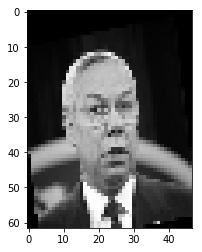

In [93]:
# Look at random images
getImage(np.random.randint(low=0, high=len(testY)))